# Tutorial 72: WORK IN PROGRESS: Longitudinal Sections

This example demonstrates how to ...

# SIR 3S Installation

In [1]:
SIR3S_SIRGRAF_DIR = r"C:\3S\SIR 3S\SirGraf-90-15-00-22_Quebec-Upd2" #change to local path

# Imports

In [2]:
from sir3stoolkit.core import wrapper

In [3]:
from sir3stoolkit.mantle import mantle

The wrapper package has to be initialized with reference to a SIR 3S (SirGraf) installation.

In [4]:
wrapper.Initialize_Toolkit(SIR3S_SIRGRAF_DIR)

## Additional imports

In [5]:
import os

...

# Initialization

In [6]:
s3s = mantle.SIR3S_Model_Mantle()

Initialization complete


# Open Model

In [7]:
dbFilePath=r"Toolkit_Tutorial72_Model.db3"

In [8]:
s3s.OpenModel(dbName=dbFilePath,
              providerType=s3s.ProviderTypes.SQLite,
              Mid="M-1-0-1",
              saveCurrentlyOpenModel=False,
              namedInstance="",
              userID="",
              password="")

Model is open for further operation


# Calculate Model

In [ ]:
s3s.ExecCalculation(True)

# Get Data

In [10]:
dfs = s3s.generate_longitudinal_section_dataframes()

[2026-02-12 18:09:20,837] INFO in sir3stoolkit.mantle.dataframes: [model_data] Generating model_data dataframe for element type: ObjectTypes.AGSN_HydraulicProfile
[2026-02-12 18:09:20,848] INFO in sir3stoolkit.mantle.dataframes: [model_data] Retrieved 3 element(s) of element type ObjectTypes.AGSN_HydraulicProfile.
[2026-02-12 18:09:20,878] INFO in sir3stoolkit.mantle.dataframes: [Resolving model_data Properties] No properties given → using ALL model_data properties for ObjectTypes.AGSN_HydraulicProfile.
[2026-02-12 18:09:20,881] INFO in sir3stoolkit.mantle.dataframes: [Resolving model_data Properties] Using 9 model_data properties.
[2026-02-12 18:09:20,887] INFO in sir3stoolkit.mantle.dataframes: [model_data] Retrieving model_data properties ['Name', 'Lfdnr', 'Aktiv', 'AllNodesAndLinks', 'ObjsString', 'MainWay', 'Tk', 'Pk', 'InVariant']...
[2026-02-12 18:09:20,958] INFO in sir3stoolkit.mantle.dataframes: [model_data] Done. Shape: (3, 10)
[2026-02-12 18:09:20,965] INFO in sir3stoolkit.m

In [11]:
df=dfs[0]

In [12]:
df_vec=s3s.add_interior_points_as_multiindex(df)

In [13]:
df_vec[("l_sum", -1)]

0       15.351701
1       27.860648
2       34.126153
3       48.533695
4       62.049538
5       79.324254
6      113.666420
7      149.752335
8      213.782486
9      265.851250
10     315.314808
11     325.177948
12     339.208532
13     371.733842
14     378.362803
15     448.136789
16     463.003848
17     562.262027
18     620.887233
19     708.601420
20     735.670985
21     740.545722
22     743.968120
23     751.727923
24     758.287896
25     777.158410
26     795.942267
27     828.020167
28     841.297316
29     911.066336
30     947.495684
31    1004.713492
32    1045.708308
33    1052.541387
34    1060.034488
35    1068.355962
36    1151.294797
37    1155.836302
38    1161.025165
39    1164.982003
40    1186.143680
41    1212.402452
42    1240.748040
43    1281.552541
Name: (l_sum, -1), dtype: float64

# Plot

In [14]:

from __future__ import annotations

from collections import OrderedDict
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def plot_time_curves(
    df: pd.DataFrame,
    start=None,
    end=None,
    properties=None,
    axis_labels=None,
    ylims=None,
    tks_per_property=None,      # kept for signature compatibility (unused in new logic)
    y_label_ticks=None,
    y_grid_ticks=None,
    x_label_ticks=None,
    x_grid_ticks=None,
    figsize=(20, 14),
    axis_offset=60,
    linestyles=None,
    legend=True,
    legend_fontsize=8,
    legend_loc="upper left",
    legend_coords=(0.67, 0.33),
    legend_in_figure=True,
    missing="skip",
    normalize=str.upper,
    aliases=None,
    title_prefix="",
    show_title=True,
    rotate_xticks=0,
    grid=True,
    grid_style="--",
    grid_alpha=0.3,
    logger=None,
):
    """
    Plot multiple properties along cumulative length.

    Expected columns:
      - ("l_sum", -1): cumulative segment end length
      - ("VAV", -1): direction; negative reverses sample order within the segment
      - For each property P in `properties`: columns (P, k) with k=0..N (level1 numeric),
        and optionally (P, -1) metadata (ignored).

    Segment definition:
      row i spans x in [l_sum[i-1], l_sum[i]] with l_sum[-1] := 0.

    For each row + property:
      - take samples from k=0 up to last non-NaN (trailing NaNs)
      - map to equidistant x over the segment
      - reverse samples if VAV < 0
    """

    # -------------------------------------------------------------------------
    # Logging helpers
    # -------------------------------------------------------------------------
    def _log_info(msg: str) -> None:
        if logger is not None:
            logger.info(f"[time curves] {msg}")

    def _log_warn(msg: str) -> None:
        if logger is not None and hasattr(logger, "warning"):
            logger.warning(f"[time curves] {msg}")
        elif logger is not None:
            logger.info(f"[time curves] {msg}")

    # -------------------------------------------------------------------------
    # Input validation
    # -------------------------------------------------------------------------
    if not isinstance(df.columns, pd.MultiIndex) or df.columns.nlevels != 2:
        raise ValueError("DataFrame must have 2-level MultiIndex columns (level0=property, level1=sample index).")

    df = df.copy()

    lvl0_name = df.columns.names[0] or "property"
    lvl1_name = df.columns.names[1] or "sample"

    def norm_prop(s: Any) -> str:
        s2 = normalize(str(s)).strip()
        if aliases:
            s2 = aliases.get(s2, s2)
        return s2

    lvl0_raw = df.columns.get_level_values(0).astype(str)
    lvl0_norm = lvl0_raw.map(norm_prop)
    lvl1_vals = df.columns.get_level_values(1)

    def _is_minus_one(x: Any) -> bool:
        return (x == -1) or (str(x).strip() == "-1")

    # Find special columns ("l_sum",-1), ("VAV",-1)
    lsum_key_norm = norm_prop("l_sum")
    vav_key_norm = norm_prop("VAV")

    lsum_mask = (lvl0_norm == lsum_key_norm) & pd.Index(lvl1_vals).map(_is_minus_one)
    vav_mask = (lvl0_norm == vav_key_norm) & pd.Index(lvl1_vals).map(_is_minus_one)


    

    lvl1_idx = pd.Index(lvl1_vals)

    lsum_mask = ((lvl0_norm == lsum_key_norm) & lvl1_idx.map(_is_minus_one)).to_numpy()
    vav_mask  = ((lvl0_norm == vav_key_norm)  & lvl1_idx.map(_is_minus_one)).to_numpy()

    if np.count_nonzero(lsum_mask) != 1:
        raise ValueError(f"Expected exactly one ('l_sum', -1) column, found {np.count_nonzero(lsum_mask)}.")
    if np.count_nonzero(vav_mask) != 1:
        raise ValueError(f"Expected exactly one ('VAV', -1) column, found {np.count_nonzero(vav_mask)}.")


    lsum_col = df.columns[lsum_mask][0]
    vav_col = df.columns[vav_mask][0]

    # Ensure l_sum numeric and sort by it
    lsum_series = pd.to_numeric(df[lsum_col], errors="coerce")
    if lsum_series.isna().any():
        bad = df.index[lsum_series.isna()].tolist()[:10]
        raise ValueError(f"Some l_sum values are NaN/non-numeric. Example rows: {bad}")

    df = df.loc[lsum_series.sort_values().index]
    lsum = lsum_series.loc[df.index].to_numpy(dtype=float)

    # Segment starts/ends
    seg_end = lsum
    seg_start = np.concatenate(([0.0], seg_end[:-1]))

    # Interpret start/end as length bounds
    start_l = float(start) if start is not None else 0.0
    end_l = float(end) if end is not None else float(seg_end.max())
    if start_l > end_l:
        raise ValueError("start must be <= end (interpreted as length range).")

    overlaps = (seg_end >= start_l) & (seg_start <= end_l)
    if not overlaps.any():
        raise ValueError("No segments overlap the requested start/end length window.")

    # -------------------------------------------------------------------------
    # Determine properties to plot
    # -------------------------------------------------------------------------
    special_norm = {lsum_key_norm, vav_key_norm}
    available_props = sorted(set(p for p in lvl0_norm.unique().tolist() if p not in special_norm))

    if properties is None:
        used_properties = available_props
    else:
        used_properties = [norm_prop(p) for p in properties]

    n_props = len(used_properties)
    if n_props == 0:
        raise ValueError("No properties to plot.")

    # -------------------------------------------------------------------------
    # Axis labels and limits
    # -------------------------------------------------------------------------
    if axis_labels is None:
        used_axis_labels = [f"{lvl0_name}={p}" for p in used_properties]
    else:
        if len(axis_labels) != n_props:
            raise ValueError("axis_labels must have same length as properties.")
        used_axis_labels = list(axis_labels)

    if ylims is not None:
        if len(ylims) != n_props:
            raise ValueError("ylims must have same length as properties (or be None).")
        for lim in ylims:
            if lim is not None and (not isinstance(lim, (tuple, list)) or len(lim) != 2):
                raise ValueError("Each ylims entry must be (ymin, ymax) or None.")

    # -------------------------------------------------------------------------
    # Tick validation
    # -------------------------------------------------------------------------
    if y_label_ticks is not None:
        if len(y_label_ticks) != n_props:
            raise ValueError("y_label_ticks must have same length as properties (or be None).")
        if any((not isinstance(n, int) or n < 2) for n in y_label_ticks):
            raise ValueError("Each y_label_ticks entry must be an int >= 2.")

    if y_grid_ticks is not None and (not isinstance(y_grid_ticks, int) or y_grid_ticks < 2):
        raise ValueError("y_grid_ticks must be an int >= 2 (or None).")

    if x_label_ticks is not None and (not isinstance(x_label_ticks, int) or x_label_ticks < 2):
        raise ValueError("x_label_ticks must be an int >= 2 (or None).")

    if x_grid_ticks is not None and (not isinstance(x_grid_ticks, int) or x_grid_ticks < 2):
        raise ValueError("x_grid_ticks must be an int >= 2 (or None).")

    # -------------------------------------------------------------------------
    # Linestyles and colors
    # -------------------------------------------------------------------------
    if linestyles is None:
        linestyles = ["-", "--", ":", "-."]
    prop_linestyle = {p: linestyles[i % len(linestyles)] for i, p in enumerate(used_properties)}

    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    if not colors:
        colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
    prop_color = {p: colors[i % len(colors)] for i, p in enumerate(used_properties)}

    # -------------------------------------------------------------------------
    # Create figure and stacked left y-axes (unchanged styling)
    # -------------------------------------------------------------------------
    fig, ax0 = plt.subplots(figsize=figsize)
    axes = [ax0]
    for i in range(1, n_props):
        ax = ax0.twinx()
        ax.yaxis.set_label_position("left")
        ax.yaxis.tick_left()
        ax.spines["left"].set_position(("outward", axis_offset * i))
        ax.spines["right"].set_visible(False)
        axes.append(ax)

    for ax in axes:
        ax.set_xlim(start_l, end_l)
        ax.margins(x=0)
        ax.autoscale(enable=False, axis="x")

    # X ticks
    if x_label_ticks is not None:
        major_xticks = np.linspace(start_l, end_l, x_label_ticks)
        ax0.xaxis.set_major_locator(mticker.FixedLocator(major_xticks))
    else:
        ax0.xaxis.set_major_locator(mticker.AutoLocator())

    if x_grid_ticks is not None:
        minor_xticks = np.linspace(start_l, end_l, x_grid_ticks)
        ax0.xaxis.set_minor_locator(mticker.FixedLocator(minor_xticks))

    if rotate_xticks:
        for lbl in ax0.get_xticklabels():
            lbl.set_rotation(rotate_xticks)
            lbl.set_ha("right")

    # -------------------------------------------------------------------------
    # Build property -> sorted sample columns (numeric level1 only)
    # -------------------------------------------------------------------------
    def _sample_index(x: Any) -> int:
        # level1 expected to be int; allow numeric strings
        try:
            return int(x)
        except Exception as e:
            raise ValueError(f"Non-numeric sample index in level1: {x!r}. Expected 0..N.") from e

    prop_to_sample_cols: dict[str, list[tuple[Any, Any]]] = {}
    for p in used_properties:
        mask_p = (lvl0_norm == p) & ~pd.Index(lvl1_vals).map(_is_minus_one)
        cols = df.columns[mask_p].tolist()
        if cols:
            cols_sorted = sorted(cols, key=lambda c: _sample_index(c[1]))
            prop_to_sample_cols[p] = cols_sorted
        else:
            prop_to_sample_cols[p] = []

    # Direction series
    vav = pd.to_numeric(df[vav_col], errors="coerce").to_numpy(dtype=float)

    # -------------------------------------------------------------------------
    # Plot segments
    # -------------------------------------------------------------------------
    all_lines = []
    plotted_any_for_property = {p: False for p in used_properties}
    labeled_property = {p: False for p in used_properties}

    idx = df.index.to_numpy()
    for i, row_idx in enumerate(idx):
        if not overlaps[i]:
            continue

        x0 = float(seg_start[i])
        x1 = float(seg_end[i])
        if x1 <= x0:
            continue

        direction_negative = (vav[i] < 0)

        for prop_idx, prop in enumerate(used_properties):
            ax = axes[prop_idx]
            cols = prop_to_sample_cols.get(prop, [])
            if not cols:
                continue

            vals = df.loc[row_idx, cols]

            notna = vals.notna().to_numpy()
            if not notna.any():
                continue

            last = int(np.where(notna)[0].max())
            vals_upto = vals.iloc[: last + 1].dropna().to_numpy(dtype=float)

            m = len(vals_upto)
            if m < 2:
                # You said this won't happen; keep safe anyway.
                continue

            if direction_negative:
                vals_upto = vals_upto[::-1]

            x_seg = np.linspace(x0, x1, m)

            label = prop if not labeled_property[prop] else "_nolegend_"
            (ln,) = ax.plot(
                x_seg,
                vals_upto,
                linestyle=prop_linestyle[prop],
                color=prop_color[prop],
                label=label,
            )

            labeled_property[prop] = True
            all_lines.append(ln)
            plotted_any_for_property[prop] = True

            ax.set_ylabel(used_axis_labels[prop_idx])
            if ylims is not None and ylims[prop_idx] is not None:
                ax.set_ylim(*ylims[prop_idx])

    # Missing property handling
    missing_props = [p for p, ok in plotted_any_for_property.items() if not ok]
    if missing_props:
        msg = f"Requested properties produced no plotted lines (missing or all-NaN): {missing_props}"
        if missing == "error":
            raise ValueError(msg)
        elif missing == "warn":
            _log_warn(msg)

    # Y ticks and y-grid ticks
    for prop_idx, ax in enumerate(axes):
        if y_label_ticks is not None:
            y0, y1 = ax.get_ylim()
            ax.set_yticks(np.linspace(y0, y1, y_label_ticks[prop_idx]))

    if y_grid_ticks is not None:
        y0, y1 = ax0.get_ylim()
        ax0.yaxis.set_minor_locator(mticker.FixedLocator(np.linspace(y0, y1, y_grid_ticks)))

    # Labels, grid, title, legend
    ax0.set_xlabel("l_sum")
    ax0.set_axisbelow(True)

    if grid:
        ax0.grid(True, which="major", axis="both", linestyle=grid_style, alpha=grid_alpha)
        if x_grid_ticks is not None:
            ax0.grid(True, which="minor", axis="x", linestyle=grid_style, alpha=grid_alpha)
        if y_grid_ticks is not None:
            ax0.grid(True, which="minor", axis="y", linestyle=grid_style, alpha=grid_alpha)

    if show_title:
        ax0.set_title(f"{title_prefix}l_sum: {start_l:g} - {end_l:g}")

    if legend:
        by_label = OrderedDict()
        for ln in all_lines:
            lab = ln.get_label()
            if lab and lab != "_nolegend_" and lab not in by_label:
                by_label[lab] = ln

        handles = list(by_label.values())
        labels = list(by_label.keys())

        if handles:
            if legend_in_figure:
                fig.legend(handles, labels, loc=legend_loc, bbox_to_anchor=legend_coords, fontsize=legend_fontsize)
            else:
                ax0.legend(handles, labels, loc=legend_loc, bbox_to_anchor=legend_coords, fontsize=legend_fontsize)

    fig.tight_layout()
    _log_info(f"Plotted {len(all_lines)} segment-lines for {n_props} properties.")
    return fig, axes, used_properties


In [15]:
s3s.GetResultProperties_from_elementType(s3s.ObjectTypes.Pipe,False)

['A',
 'ACALC',
 'CPI',
 'CPK',
 'DH',
 'DP',
 'DRAGRED',
 'DRAKONZ',
 'DSI',
 'DSK',
 'DTTR',
 'DWVERL',
 'DWVERLABS',
 'ETAAV',
 'FS',
 'HR',
 'HVEC',
 'IAKTIV',
 'IRTRENN',
 'JV',
 'JV2',
 'LAMBDA',
 'LECKEINAUS',
 'LECKMENGE',
 'LECKORT',
 'LINEPACK',
 'LINEPACKGEOM',
 'LINEPACKRATE',
 'MAINELEMENT',
 'MAV',
 'MI',
 'MK',
 'MKOND',
 'MMAX_INST',
 'MMIN_INST',
 'MVEC',
 'MVECMAX_INST',
 'MVECMIN_INST',
 'PAV',
 'PDAMPF',
 'PHR',
 'PHVEC',
 'PMAX',
 'PMIN',
 'PR',
 'PVEC',
 'PVECMAX_INST',
 'PVECMIN_INST',
 'QI2',
 'QK2',
 'QMAV',
 'QMI',
 'QMK',
 'QMMAX_INST',
 'QMMIN_INST',
 'QMVEC',
 'QSVB',
 'RHOAV',
 'RHOI',
 'RHOK',
 'RHOVEC',
 'SVEC',
 'TAV',
 'TI',
 'TK',
 'TTRVEC',
 'TVEC',
 'TVECMAX_INST',
 'TVECMIN_INST',
 'VAV',
 'VI',
 'VK',
 'VMAX_INST',
 'VMIN_INST',
 'VOLDA',
 'WALTERI',
 'WALTERK',
 'WVL',
 'ZAUS',
 'ZEIN',
 'ZHKNR',
 'ZVEC']

In [16]:
df_vec.head(3)

tk                    Name  \
interior points                  -1                      -1    
0                5691533564979419761      Rohr V-E0 V-K1683S   
1                5048873293262650113  Rohr V-K1683S V-K1693S   
2                5715081934973525403  Rohr V-K2163S V-K1693S   

                          FkdtroRowd               Fkltgr  \
interior points                  -1                   -1    
0                4816511167455310973  4779752876656844188   
1                4816511167455310973  4779752876656844188   
2                4816511167455310973  4779752876656844188   

                           Fkstrasse          L Lzu   Rau Jlambs Lambda0 Zein  \
interior points                  -1         -1  -1    -1     -1      -1   -1    
0                5204829332281547346  15.351700   0  0.05      1       0    0   
1                5204829332281547346  12.508950   0  0.05      1       0    0   
2                5204829332281547346   6.265505   0  0.05      1       0    0   

                Zaus Zuml Asoll Indschall Baujahr Hal               Fkcont  \
interior points  -1   -1    -1        -1      -1  -1                   -1    
0                  0    0  1000         0           0  5029128874972463118   
1                  0    0  1000         0           0  5029128874972463118   
2                  0    0  1000         0           0  5029128874972463118   

                            Fk2lrohr  \
interior points                  -1    
0                5025945677694931826   
1                5216742060270992761   
2                4919359344392474301   

                                                      Beschreibung Idreferenz  \
interior points                                                -1         -1    
0                OSM: Knoten 476971238 -> Knoten 299394923; Län...   39785520   
1                OSM: Knoten 299394923 -> Knoten 4105649557; Lä...   39785520   
2                OSM: Knoten 299394922 -> Knoten 4105649557; Lä...  595926249   

                Iplanung Kvr LineWidthMM DottedLine   DN     Di KvrKlartext  \
interior points      -1  -1          -1         -1   -1     -1          -1    
0                      0   1       0.005          0  350  345.6     Vorlauf   
1                      0   1       0.005          0  350  345.6     Vorlauf   
2                      0   1       0.005          0  350  345.6     Vorlauf   

                HasClosedNSCHs                   Tk                   Pk  \
interior points            -1                   -1                   -1    
0                               5691533564979419761  5691533564979419761   
1                               5048873293262650113  5048873293262650113   
2                               5715081934973525403  5715081934973525403   

                InVariant           Xkor          Ykor GeometriesDiffer  \
interior points       -1             -1            -1               -1    
0                   False  713619.921383  5.578219e+06            False   
1                   False  713614.648712  5.578233e+06            False   
2                   False  713614.369043  5.578252e+06            False   

                               bz.Fk bz.Qsvb bz.Irtrenn bz.Leckstatus  \
interior points                  -1      -1         -1            -1    
0                5691533564979419761       0          0             0   
1                5048873293262650113       0          0             0   
2                5715081934973525403       0          0             0   

                bz.Leckstart bz.Leckend bz.Leckort bz.Leckmenge bz.Imptnz  \
interior points          -1         -1         -1           -1        -1    
0                          0          0          0            0         0   
1                          0          0          0            0         0   
2                          0          0          0            0         0   

                bz.Zvlimptnz bz.Kantenzv bz.ITrennWithNSCH  \
interior points          -1         

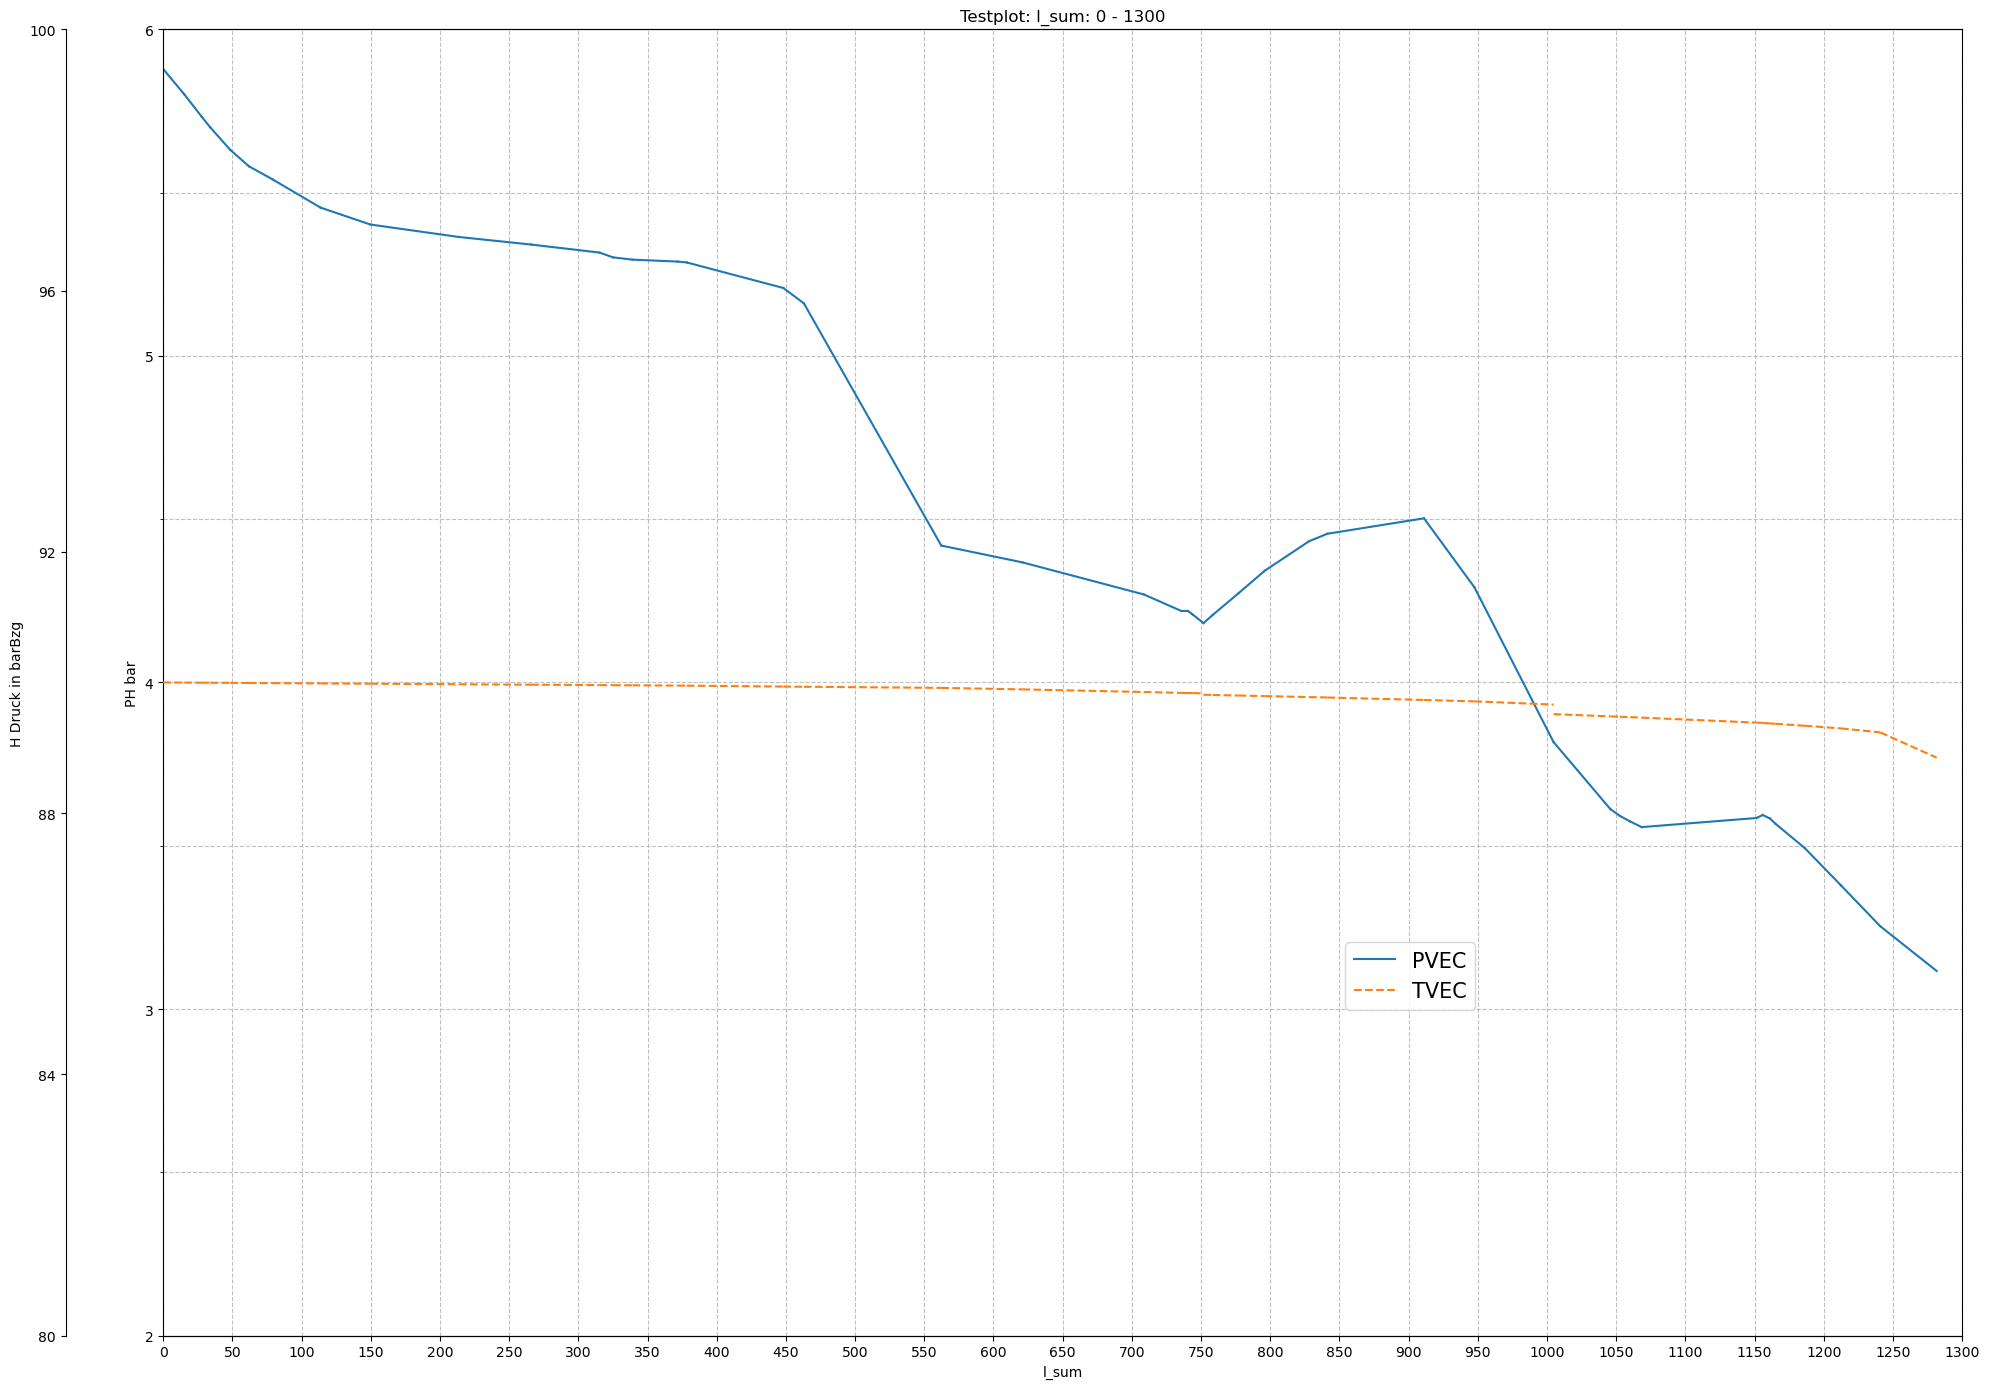

In [17]:
fig, axes, used = plot_time_curves(
    df=df_vec,

    # NEW: interpreted as length window on l_sum (floats), not timestamps
    start=0.0,
    end=1300,  # <-- set this to the l_sum range you want

    properties=["PVEC", "TVEC"],
    axis_labels=["PH bar", "H Druck in barBzg"],
    ylims=[(2, 6), (80, 100)],

    # kept for compatibility but not used by the new logic (can be omitted)
    # tks_per_property=...,

    y_label_ticks=[5, 6],
    y_grid_ticks=9,
    x_label_ticks=27,
    x_grid_ticks=14,

    legend=True,
    legend_in_figure=True,
    legend_loc="upper left",
    legend_coords=(0.67, 0.33),
    legend_fontsize=15,

    title_prefix="Testplot: ",
    show_title=True,

    axis_offset=70,
    linestyles=["-", "--", ":"],
    rotate_xticks=0,

    grid=True,
    grid_style="--",
    grid_alpha=0.8,

    missing="warn",
    logger=None,
)


In [18]:
1/0

ZeroDivisionError: division by zero

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
def plot(dfAGSN=pd.DataFrame()
        ,dfAGSNRL=pd.DataFrame()
        ,PHCol='("PVEC", "0")'
        ,mlcCol='mlc_n'
        ,zKoorCol='ZKOR_n'
        ,barBzgCol='H_n'
        ,QMCol='QM'
        ,TCol='T_n'
        ,xCol='LSum'
        
):
                       
    fig, ax0 = plt.subplots(figsize=(20,11.9))
    
    ax0.set_yticks(np.linspace(0, 10, 21))
    ax0.yaxis.set_ticklabels([])
    ax0.grid()

    #PH
    ax1 = ax0.twinx()     
    fyPH(ax1) 
    PH_SL=ax1.plot(dfAGSN[xCol], dfAGSN[PHCol], color='red', label='PH SL',ls='dotted')
    PH_RL=ax1.plot(dfAGSNRL[xCol], dfAGSNRL[PHCol], color='blue', label='PH RL',ls='dotted')
    
    #mlc
    ax11 = ax0.twinx()     
    fymlc(ax11) 
    mlc_SL=ax11.plot(dfAGSN[xCol], dfAGSN[mlcCol], color='red', label='mlc SL')
    mlc_RL=ax11.plot(dfAGSNRL[xCol], dfAGSNRL[mlcCol], color='blue', label='mlc RL')
    
    z=ax11.plot(dfAGSN[xCol], dfAGSN[zKoorCol], color='black', label='z',ls='dashed',alpha=.5)
    
    #barBZG
    ax12 = ax0.twinx()     
    fybarBzg(ax12) 
    barB_SL=ax12.plot(dfAGSN[xCol], dfAGSN[barBzgCol], color='red', label='H SL',ls='dashdot')
    barB_RL=ax12.plot(dfAGSNRL[xCol], dfAGSNRL[barBzgCol], color='blue', label='H RL',ls='dashdot')
    """
    #M
    ax2 = ax0.twinx()     
    fyM(ax2)
    QM_SL=ax2.step(dfAGSN[xCol], dfAGSN[QMCol]*dfAGSN['direction'], color='orange', label='M SL')
    QM_RL=ax2.step(dfAGSNRL[xCol], dfAGSNRL[QMCol]*dfAGSNRL['direction'], color='cyan', label='M RL',ls='--')
    
    #T
    ax3 = ax0.twinx() 
    fyT(ax3)
    T_SL=ax3.plot(dfAGSN[xCol], dfAGSN[TCol], color='pink', label='T SL')
    T_RL=ax3.plot(dfAGSNRL[xCol], dfAGSNRL[TCol], color='lavender', label='T RL')
    """
    ax0.set_title('Longitudinal Section for ')#+dbFilename)

    # added these three lines
    lns =  PH_SL+ PH_RL + mlc_SL+ mlc_RL + barB_SL+ barB_RL#+ QM_SL+ QM_RL + T_SL+ T_RL + z
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs)#, loc=0)
    
    plt.show()

In [ ]:
def plot(
    dfAGSN=df_vec,
    xCol="l_sum",
    PHCol=("PVEC", 0),
    barBzgCol=("HVEC", 0)
):
    fig, ax0 = plt.subplots(figsize=(20,11.9))
    
    ax0.set_yticks(np.linspace(0, 10, 21))
    ax0.yaxis.set_ticklabels([])
    ax0.grid()

    #PH
    ax1 = ax0.twinx()     
    fyPH(ax1) 
    PH_SL=ax1.plot(dfAGSN[xCol], dfAGSN[PHCol], color='red', label='PH SL',ls='dotted')
    #PH_RL=ax1.plot(dfAGSNRL[xCol], dfAGSNRL[PHCol], color='blue', label='PH RL',ls='dotted')

    #barBZG
    ax12 = ax0.twinx()     
    fybarBzg(ax12) 
    barB_SL=ax12.plot(dfAGSN[xCol], dfAGSN[barBzgCol], color='red', label='H SL',ls='dashdot')
    
    ax0.set_title('Longitudinal Section for ')#+dbFilename)

    # added these three lines
    lns =  PH_SL + barB_SL#+ PH_RL + mlc_SL+ mlc_RL + barB_SL+ barB_RL#+ QM_SL+ QM_RL + T_SL+ T_RL + z
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs)#, loc=0)
    
    plt.show()
    

NameError: name 'np' is not defined

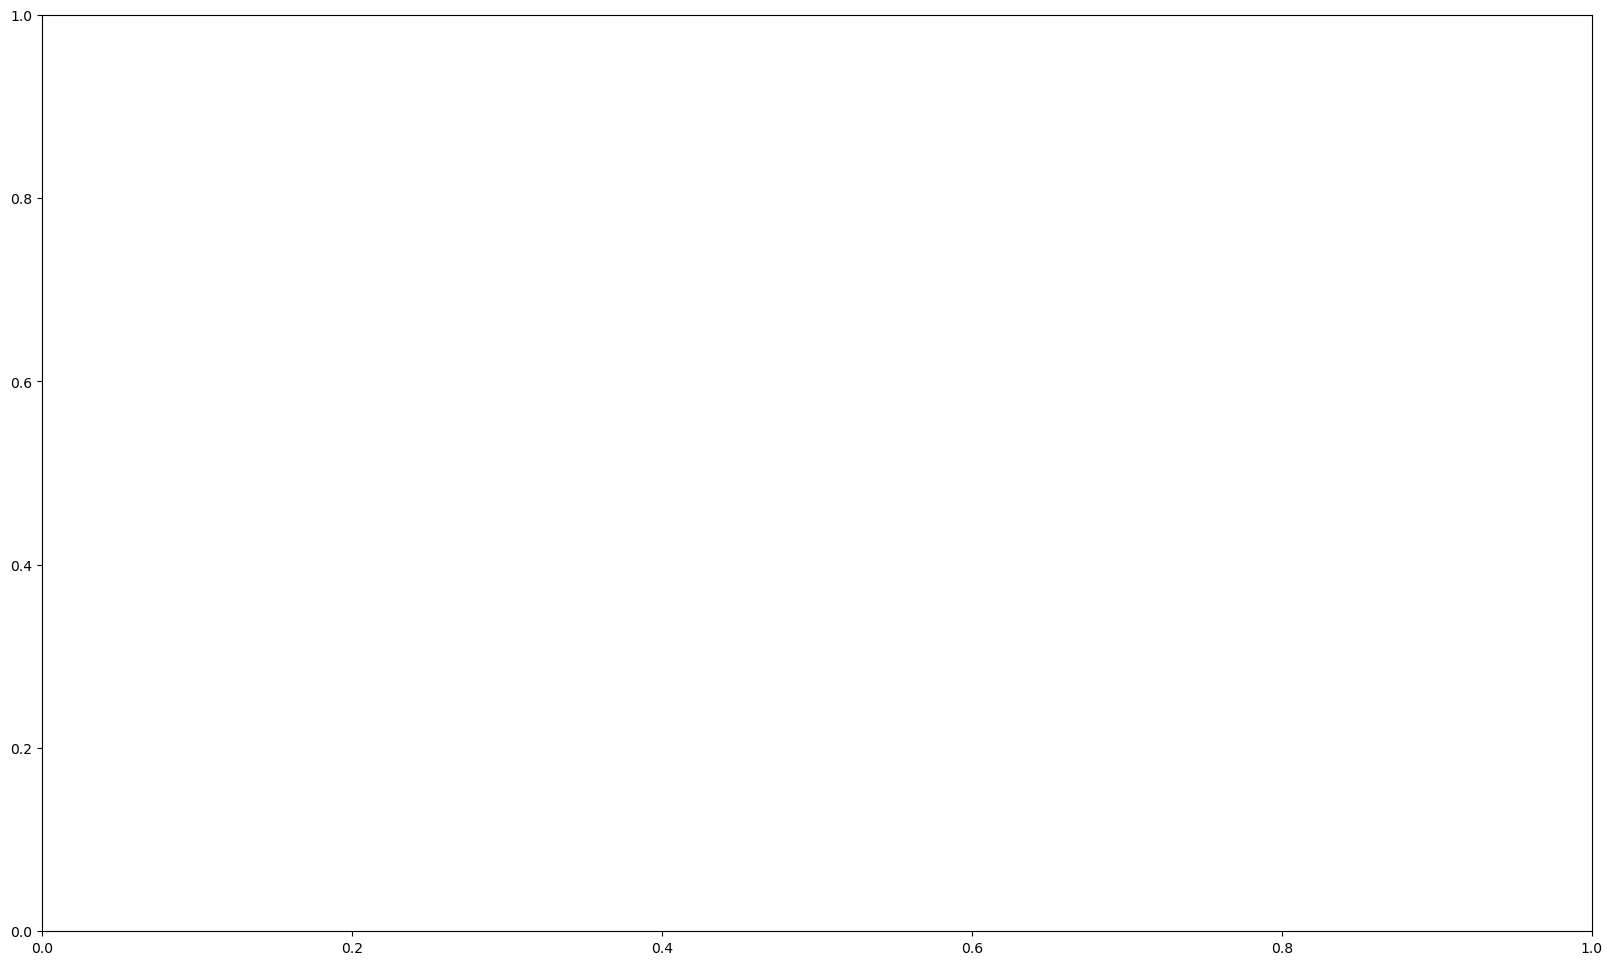

In [ ]:
plot(df_vec)

...